In [15]:
##Preable
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
import pickle
import pandas as pd
from matplotlib.patches import Polygon

from EightBitTransit.cTransitingImage import TransitingImage
from EightBitTransit.inversion import *
from EightBitTransit.misc import *

%matplotlib inline

In [16]:
def fillShape(grid, shapes):
    """Creates a grid with the shape bound by given points filled in.
    Points in the sublists are connected in the order they are given
    Sublists are not connected to each other

    Args:
        grid (list) - list of grid coordinates as tuples
        shapes (list) - list of shapes, each entry is a collection of points
            defining the vertices of a polygon

    Returns:
    """
    # Create a grid to plot the outline on
    # need a binary image to simulate transits
    grid_df = pd.DataFrame(data=grid, columns=['x', 'y'])  # df is easier to work with
    grid_shape = [grid_df.x.max(), grid_df.y.max()]
    outline = np.zeros(grid_shape) 

    for shape in shapes:
        points_df = pd.DataFrame(data=shape, columns=['x', 'y'])
        polygon = Polygon(points_df)
        test_inside_mask = polygon.contains_points(grid)
        outline[grid_df[test_inside_mask].x, grid_df[test_inside_mask].y] = 1

    return outline

In [17]:
def duplicateShape(n, grid): ##Recursively adds the grid to itself n times
    if n == 1:
        return grid
    largerGrid = duplicateShape(n-1,grid)
    outputGrid = np.zeros([len(grid),len(grid[0])+len(largerGrid[0])])
    for i in range(len(outputGrid)):
        outputGrid[i] = np.append(largerGrid[i],grid[i])
    return outputGrid

In [18]:
def generatePoints(n,r,xoffset = 0,yoffset = 0,rotation = 0,proportion = 1): ##Generates points of a regular polygon with n edges, radius of r*size
    ##Size is grid size, 0 < r < 0.5, rotation rotates the shape from having a point vertically down
    points = []
    ystretch = np.sqrt(proportion)
    xstretch = 1/np.sqrt(proportion)
    for i in range(n):
        y = int(ystretch*r*np.cos(i*2*np.pi/n + np.pi/n))
        x = int(xstretch*r*np.sin(i*2*np.pi/n + np.pi/n))
        nuy = int(x*np.sin(rotation)+y*np.cos(rotation) + yoffset)
        nux = int(x*np.cos(rotation)-y*np.sin(rotation) + xoffset)
        points.append([nuy,nux])
    return points

In [19]:
def getTimes(filename): ##Gets the time array from the TESS Light Curve
    fp = open("./"+filename+".pkl","rb") ##Loading the file
    data = pickle.load(fp)
    fp.close()
    
    q = data[11]==0
    times = data[6][q]
    return times

In [20]:
def model(sides,radius,rotation,stretch,velocity, objects, separation, tRef, times):
    points = generatePoints(sides,radius,(1/np.sqrt(stretch))*radius+1,50,rotation,stretch)
    pointsList = [points]
    grid = []
    for i in range(100):
        for j in range(int(2*(1/np.sqrt(stretch))*radius + 2 + separation)):
            grid.append((i,j))
    planetGrid = fillShape(grid,pointsList)
    planetGrid = duplicateShape(objects, planetGrid)
    planet = TransitingImage(opacitymat = planetGrid, v = velocity, t_ref = tRef, t_arr = times)
    planetLC, overlapTimes = planet.gen_LC(t_arr = times)
    planet.plot_grid()
    return planetLC, overlapTimes
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


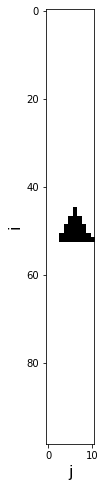

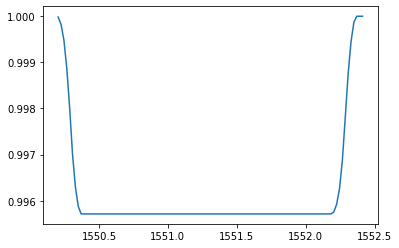

In [23]:
times = getTimes('tesslc_148560484')
midTime = np.percentile(times,33)
planetLC, overlapTimes = model(3,5,0,1,1,1,0,midTime,times)
plt.plot(overlapTimes, planetLC)
plt.show()

In [89]:
##